In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df=pd.read_csv(path)
    json_columns=['cast','crew']
    for column in json_columns:
        df[column]=df[column].apply(json.loads)
    return df

LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()

    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)

    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)

    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))

    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))

    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))

    tmdb_movies['actor_4_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))

    tmdb_movies['actor_5_name'] = credits['cast'].apply(lambda x: safe_access(x, [4, 'name']))


    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    tmdb_movies['production_companies']=tmdb_movies['production_companies'].apply(pipe_flatten_names)
    return tmdb_movies

movies=load_tmdb_movies('tmdb_5000_movies.csv')

credits=load_tmdb_credits('tmdb_5000_credits.csv')

original_format =convert_to_original_format(movies, credits)


original_format.info()
original_format.head()

movies.info(),print('-'*50),credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 28 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
plot_keywords           4803 non-null object
language                4717 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
gross                   4803 non-null int64
duration                4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
movie_title             4803 non-null object
vote_average            4803 non-null float64
num_voted_users         4803 non-null 

(None, None, None)

In [3]:
corrDF=original_format.corr()
corrDF['gross'].sort_values(ascending=False)

gross              1.000000
num_voted_users    0.781487
budget             0.730823
popularity         0.644724
duration           0.251093
vote_average       0.197150
title_year         0.090192
id                -0.050425
Name: gross, dtype: float64

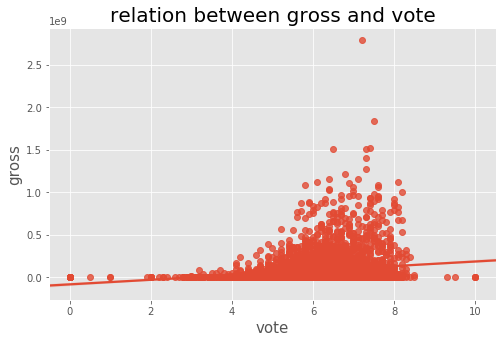

In [4]:
plt.style.use('ggplot')
f,ax=plt.subplots(figsize=(8,5))
sns.regplot(x='vote_average',y='gross',data=original_format,ax=ax)
plt.title('relation between gross and vote',fontsize='20')
plt.xlabel('vote',fontsize='15')
plt.ylabel('gross',fontsize='15')
plt.grid(True)

plt.savefig('GroosVSVote.jpg',bbox_inches='tight')
plt.show()

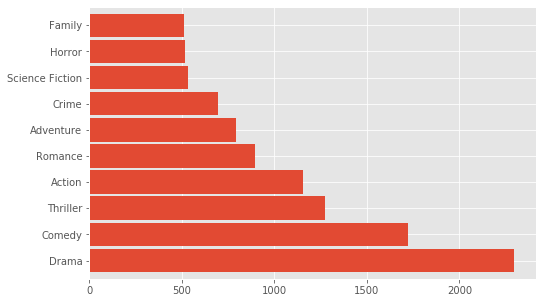

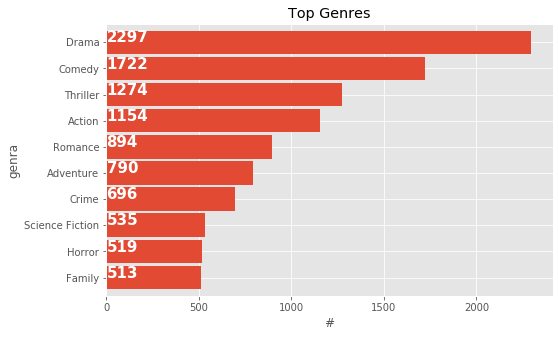

In [5]:
dataGdf=pd.DataFrame(original_format['genres'])
dataGdf=dataGdf.reset_index(drop=True)
dataGdf['genres'].head()
dataGdf['genres']=dataGdf['genres'].str.split('|')
dataGdf['genres'].head()
list1=[]
for i in dataGdf['genres']:
    list1.extend(i)

ax=pd.Series(list1)
ax.describe()
plt.subplots(figsize=(8,5))
ax.value_counts()[0:10].plot(kind='barh',width=0.9)
ax2=ax.value_counts()[0:10].sort_values(ascending=True)

plt.subplots(figsize=(8,5))
ax3=ax2.plot(kind='barh',width=0.9)

for i, v in enumerate(ax2.values):
    ax3.text(1,i,v,fontsize='15',color='white',weight='bold')

plt.title('Top Genres')
plt.xlabel('#')
plt.ylabel('genra')
plt.savefig('Most_Frequent_genra.jpg')
plt.show()

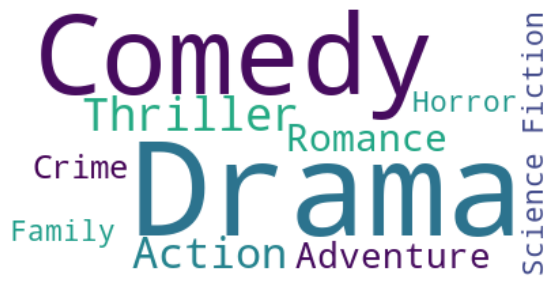

In [6]:
wc=WordCloud(background_color='white',max_words=2000,random_state=1).\
    generate_from_frequencies(ax2.to_dict())

plt.figure(figsize=(10,5))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.savefig('TopGenresCloud.jpg')
plt.show()


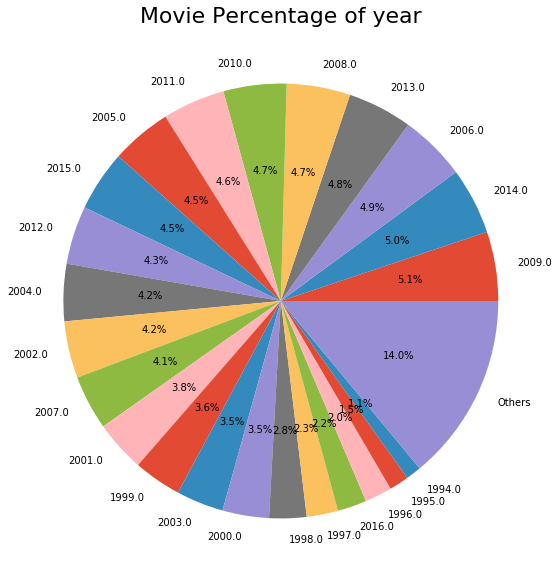

In [8]:
year_df=original_format['title_year'].value_counts()
year_df=year_df/year_df.sum()

year_df2=year_df[year_df>=0.01]
year_df2['Others']=year_df[year_df<0.01].sum()

# explode = (len(year_df2))
year_df2.plot(kind='pie',label='',startangle=0,shadow=False,
            figsize=(10,10),autopct="%1.1f%%")

plt.title('Movie Percentage of year',fontsize='22')
plt.savefig('YearWithMostMoive.jpg')
plt.show()


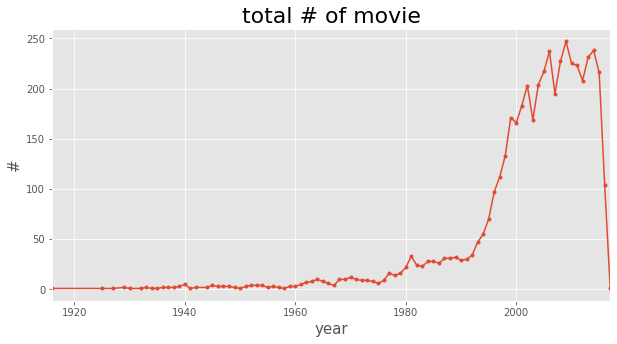

In [9]:
movies_year_count=original_format.groupby(['title_year'])['movie_title'].count()
movies_year_count.plot(figsize=(10,5),marker='.')
plt.title('total # of movie',fontsize=22)
plt.xlabel('year',fontsize=15)
plt.ylabel('#',fontsize=15)
plt.savefig('MovieOfEachYear.png')
plt.show()


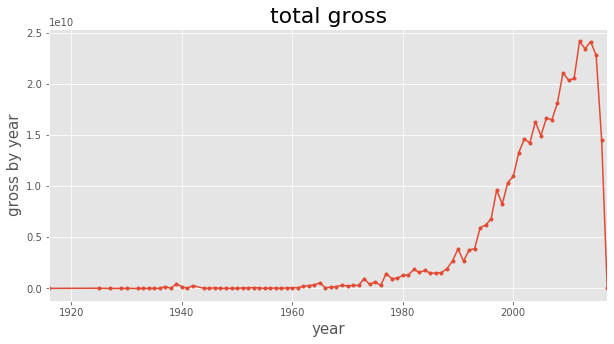

In [10]:
movies_year_gross=original_format.groupby(['title_year'])['gross'].sum()
movies_year_gross.plot(figsize=(10,5),marker='.')
plt.title('total gross',fontsize=22)
plt.xlabel('year',fontsize=15)
plt.ylabel('gross by year',fontsize=15)
plt.savefig('TotalGross.jpg')
plt.show()


['', 'Western', 'History', 'Comedy', 'Horror', 'TV Movie', 'Foreign', 'Drama', 'Documentary', 'Adventure', 'Mystery', 'Romance', 'Fantasy', 'Action', 'Music', 'Science Fiction', 'Family', 'Crime', 'Thriller', 'War', 'Animation']
['Western', 'History', 'Comedy', 'Horror', 'TV Movie', 'Foreign', 'Drama', 'Documentary', 'Adventure', 'Mystery', 'Romance', 'Fantasy', 'Action', 'Music', 'Science Fiction', 'Family', 'Crime', 'Thriller', 'War', 'Animation']
['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', 'TV Movie', '']
1916 2017
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 1916 to 2017
Data columns (total 21 columns):
Action             102 non-null int64
Adventure          102 non-null int64
Fantasy            102 non-null int64
Science Fiction    102 non-null int64
Crime              102 non-null int64
Drama   

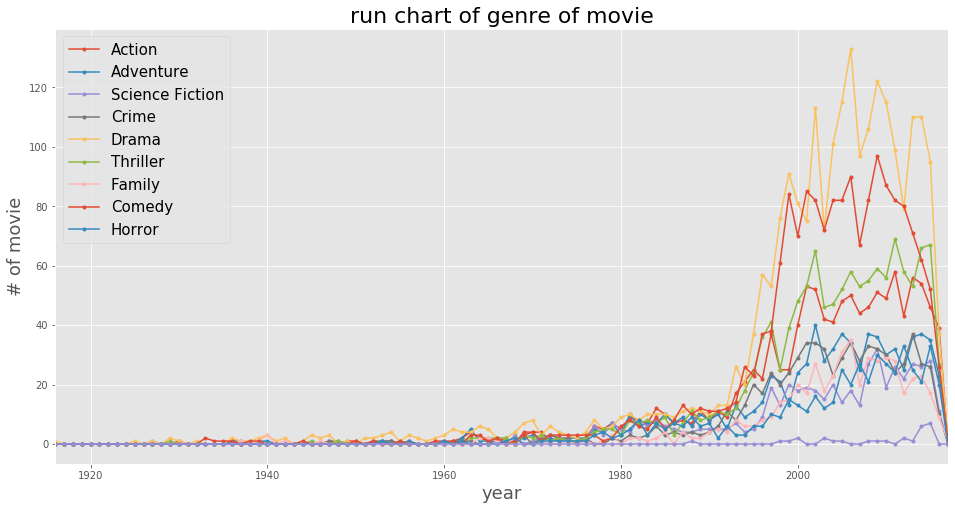

In [14]:
movies_genres=original_format.loc[:,['title_year','genres']]
list_genres=set()
for i in original_format['genres'].str.split('|'):
    list_genres=set().union(i,list_genres)
list_genres=list(list_genres)
print(list_genres)
list_genres.remove('')
print(list_genres)
df_reduced=pd.DataFrame()
df_reduced['title_year']=movies_genres['title_year']

for genre in list_genres:
    df_reduced['genre']=movies_genres['genres'].str.contains(genre).apply(lambda x:1 if x else 0)
    df_reduced=df_reduced.sort_values(by='title_year',ascending=True)

genre_details=list(map(str,(original_format['genres'])))

genre=[]
for i in genre_details:
    split_genre=list(map(str,i.split('|')))
    for j in split_genre:
        if j not in genre:
            genre.append(j)
print(genre)
original_format['title_year']=original_format['title_year'].astype('int')
min_year=original_format['title_year'].min()
max_year=original_format['title_year'].max()
print(min_year,max_year)
genre_df=pd.DataFrame(index=range(min_year,max_year+1),columns=genre)
genre_df=genre_df.fillna(value=0)
genre_df.info()
genre_df.head()
year=np.array(original_format['title_year'])
z=0
for i in genre_details:
    split_genre=list(map(str,i.split('|')))
    for j in split_genre:
        genre_df.loc[year[z],j]=genre_df.loc[year[z],j]+1
    z+=1
genre_df.info()
ax2
genre_df=genre_df.drop(['Fantasy','Animation','Western','Romance','Mystery','History','War','Music','Documentary','Foreign','TV Movie'],axis=1)
genre_df.head()
genre_df1=genre_df.copy()
genre_df1.rename(columns={'Action':'Action',
                         'Adventure':'Adventure',
                         'Science Fiction':'Science Fiction',
                         'Crime':'Crime',
                         'Drama':'Drama',
                         'Thriller':'Thriller',
                         'Family':'Family',
                         'Comedy':'Comedy',
                         'Horror':'Horror'},inplace=True)
genre_df1.head()
genre_df1.plot(figsize=(16,8),marker='.')
plt.grid(True)
plt.title('run chart of genre of movie',fontsize=22)
plt.xlabel('year',fontsize=18)
plt.ylabel('# of movie',fontsize=18)
plt.legend(fontsize=15)
plt.savefig('GenraVStime.jpg')
plt.show()

In [12]:
original_format.count().sort_values(ascending=False)
columnList=original_format.columns
for i in columnList:
    if original_format[i].count() < 4803:
        print (i,':',original_format[i].count())
original_format=original_format.drop('homepage',axis=1)
original_format['language'].value_counts()
original_format['language']=original_format['language'].fillna('English')
original_format['duration']=original_format['duration'].fillna(original_format['duration'].mean())
original_format['overview']=original_format['overview'].fillna('U')
original_format['title_year'].value_counts()
original_format['title_year']=original_format['title_year'].fillna('2009.0')
original_format['title_year']=original_format['title_year'].astype('float')
original_format['country'].value_counts()
original_format['country']=original_format['country'].fillna('United States of America')
original_format['tagline']=original_format['tagline'].fillna('U')
original_format['director_name']=original_format['director_name'].fillna('U')
original_format['actor_1_name']=original_format['actor_1_name'].fillna('U')
original_format['actor_2_name']=original_format['actor_2_name'].fillna('U')
original_format['actor_3_name']=original_format['actor_3_name'].fillna('U')
original_format['actor_4_name']=original_format['actor_4_name'].fillna('U')
original_format['actor_5_name']=original_format['actor_5_name'].fillna('U')
original_format.info()

corrDF=original_format.corr()
corrDF['gross'].sort_values(ascending=False)

homepage : 1712
language : 4717
overview : 4800
release_date : 4802
duration : 4801
tagline : 3959
title_year : 4802
country : 4629
director_name : 4773
actor_1_name : 4760
actor_2_name : 4750
actor_3_name : 4740
actor_4_name : 4710
actor_5_name : 4634
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 27 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
id                      4803 non-null int64
plot_keywords           4803 non-null object
language                4803 non-null object
original_title          4803 non-null object
overview                4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
gross                   4803 non-null int64
duration                4803 non-null float64
spoken_languages        4803 non-null object
status     

gross              1.000000
num_voted_users    0.781487
budget             0.730823
popularity         0.644724
duration           0.251080
vote_average       0.197150
title_year         0.090131
id                -0.050425
Name: gross, dtype: float64

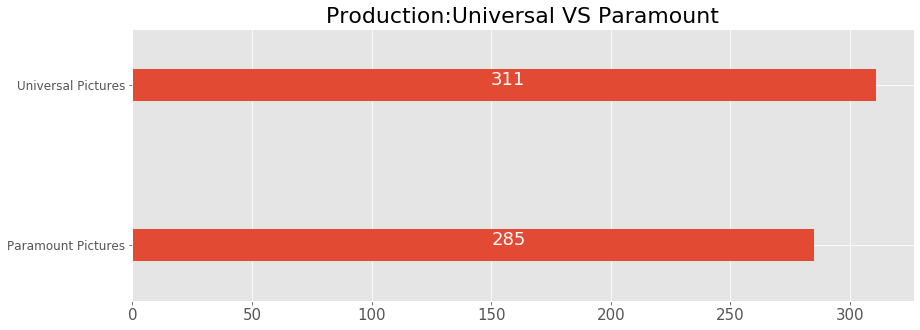

In [15]:
companies=pd.DataFrame()
companies['production_companies']=original_format['production_companies']
companies=companies[(True^companies['production_companies'].isin(['']))]
companies['production_companies']=companies['production_companies'].str.split('|')
list2=[]
for i in companies['production_companies']:
    list2.extend(i)
companiesSeries=pd.Series(list2)
companiesSeries.value_counts()
companiesSeries2=companiesSeries.value_counts()['Universal Pictures':'Paramount Pictures'].sort_values(ascending=True)
companiesSeries2
fig,ax=plt.subplots(figsize=(14,5))
companiesSeries2.plot(ax=ax,kind='barh',width=0.2)
plt.title('Production:Universal VS Paramount',fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.text(150,0,'285',fontsize=18,color='white')
plt.text(150,1,'311',fontsize=18,color='white')
fig.savefig('UniversalVSParamount.jpg')
plt.show()

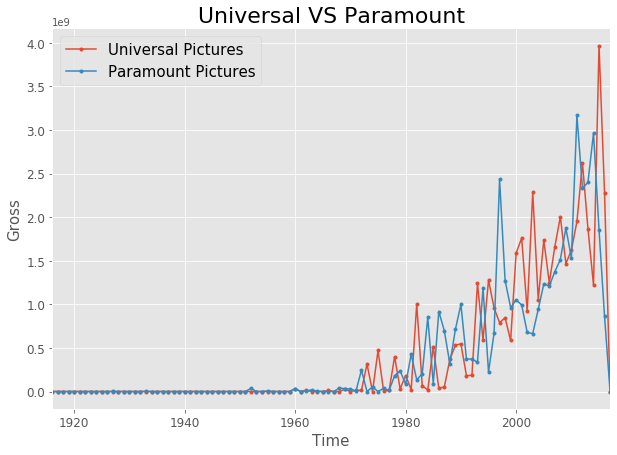

,Universal Pictures,Paramount Pictures
count,1.020000e+02,1.020000e+02
mean,4.175340e+08,4.007698e+08
std,7.473133e+08,7.003335e+08
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.875000e+06
75%,5.428051e+08,6.666067e+08
max,3.967883e+09,3.165882e+09


In [17]:

companiesGross=original_format[['production_companies','gross']]
list_companies=set()

for i in companiesGross['production_companies'].str.split('|'):
    list_companies=set().union(i,list_companies)
list_companies=list(list_companies)
list_companies.remove('')

df_reduced2=pd.DataFrame()
df_reduced2['title_year']=original_format['title_year']

for i in list_companies:
    df_reduced2['companies']=companiesGross['production_companies'].str.contains(i).apply(lambda x: 1 if x else 0)

df_reduced2=df_reduced.sort_values(by='title_year',ascending=True)

companies_details=list(map(str,(companiesGross['production_companies'])))
companies_list=[]

for i in companies_details:
    split_companies=list(map(str,i.split('|')))
    for j in split_companies:
        if j not in companies_list:
            companies_list.append(j)
companies_df=pd.DataFrame(index=range(min_year,max_year+1),columns=companies_list)
companies_df=companies_df.fillna(value=0)
companies_df.head()
companies_1=np.array(original_format['gross'])
z=0
for i in companies_details:
    split_companies=list(map(str,i.split('|')))
    for j in split_companies:
            companies_df.loc[year[z],j]=companies_df.loc[year[z],j]+companies_1[z]
    z+=1
productionDF=companies_df[['Universal Pictures','Paramount Pictures']]
productionDF2=productionDF.copy()
fig,ax=plt.subplots(figsize=(10,7))
productionDF2.plot(ax=ax,marker='.')

plt.title('Universal VS Paramount',fontsize=22)
plt.xlabel('Time',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Gross',fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
fig.savefig('Gross:UniversalVSParamount',transparent=False,bbox_inches='tight')
plt.savefig('Gross:UniversalVSParamount2',transparent=True,bbox_inches='tight')
plt.show()
productionDF2.describe()


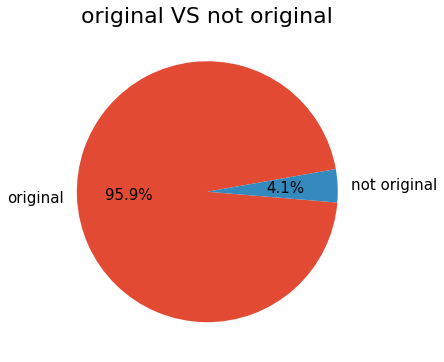

In [18]:
original_format.loc[7,'plot_keywords']
source_df=pd.DataFrame()
source_df['plot_keywords']=original_format['plot_keywords'].str.split('|')
source_df['plot_keywords'][7]
source_df['conut']=original_format['plot_keywords'].str.contains('based on novel').apply(lambda x: 'not original' if x else 'original')
original_count2=source_df['conut'].value_counts()
original_count3=pd.Series(original_count2)
fig,ax=plt.subplots(figsize=(6,6))

original_count3.plot(ax=ax,kind="pie",label='',shadow=False,autopct="%1.1f%%",startangle=10,fontsize=15)
plt.title('original VS not original',fontsize=22)
fig.savefig('OriginalVSNot',transparent=False,bbox_inches='tight')
plt.show()

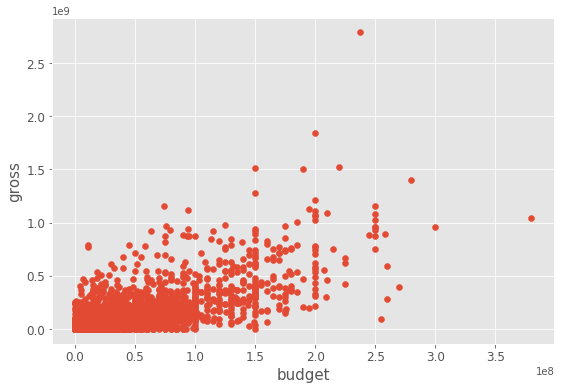

In [19]:
moneyDF=pd.DataFrame()
moneyDF=pd.concat([original_format['budget'],original_format['gross']],axis=1)
moneyDF.head()
fig,ax=plt.subplots(figsize=(9,6))
plt.scatter(x=moneyDF['budget'],y=moneyDF['gross'])
plt.title('',fontsize=22)
plt.xlabel('budget',fontsize=15)
plt.ylabel('gross',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('BudgetVSGross',bbox_inches='tight')
plt.show()

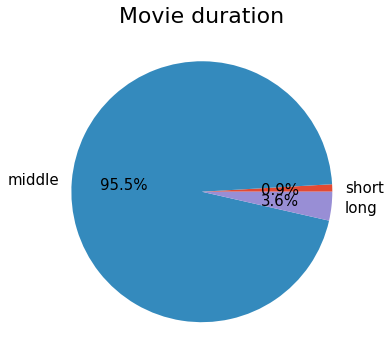

In [20]:
moviestimeDF=pd.DataFrame()
moviestimeDF['short']=original_format['duration'].map(lambda x: 1 if x<=60 else 0)
moviestimeDF['middle']=original_format['duration'].map(lambda x: 1 if 60<x<=150 else 0)
moviestimeDF['long']=original_format['duration'].map(lambda x: 1 if x>150 else 0)
shortmovie=moviestimeDF['short'].sum()
middlemovie=moviestimeDF['middle'].sum()
longmovie=moviestimeDF['long'].sum()
moviestimeSeries={'short':shortmovie,
                  'middle':middlemovie,
                  'long':longmovie}
moviestimeSeries=pd.Series(moviestimeSeries)
fig,ax=plt.subplots(figsize=(6,6))
moviestimeSeries.plot(kind='pie',label='',fontsize=15,autopct="%1.1f%%")
plt.title('Movie duration',fontsize=22)
fig.savefig('MovieDuration',bbox_inches='tight')
plt.show()